In [2]:
from vedo import embedWindow
embedWindow(None)

from brainrender import Scene
import brainrender
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.getcwd()

'C:\\Users\\thoma\\Documents\\M1_Neurasmus\\NeuroBIM_M1\\Internship\\GitRepo\\PathoSpreading'

## Plotting figure 2

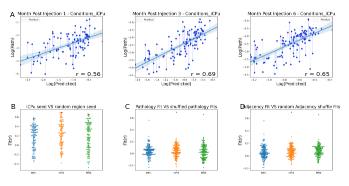

In [83]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

timepoint=[1,3,6]
image=[]
for tp in timepoint:
    Cor = Image.open("../Data_ReScience/iCPu/Predicted_VS_Path_MPI{}_iCPu.png".format(tp))
    image.append(Cor)

rnd_seed = Image.open("../Data_ReScience/iCPu/Random_Seed.png")
rnd_patho = Image.open("../Data_ReScience/iCPu/Random_Patho_iCPu.png")
rnd_adj = Image.open("../Data_ReScience/iCPu/Random_Adja_iCPu.png")

fig= plt.figure()
G = gridspec.GridSpec(nrows=6, ncols=6)
V = gridspec.GridSpec(nrows=6, ncols=6)

axes_1 = fig.add_subplot(G[0:4, 0:2])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("A",(50,175), fontsize=7, color="black")
plt.annotate("r = 0.56",(1250,1250), fontsize=6, color="black")
plt.imshow(image[0])

axes_2 = fig.add_subplot(G[0:4,2:4])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.annotate("B",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.69",(1250,1250), fontsize=6, color="black")
plt.imshow(image[1])

axes_3 = fig.add_subplot(G[0:4, 4:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.annotate("C",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.65",(1250,1250), fontsize=6, color="black")
plt.imshow(image[2])

axes_4 = fig.add_subplot(V[3:7,0:2])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("B",(50,150), fontsize=7, color="black")
plt.imshow(rnd_seed)

axes_5 = fig.add_subplot(V[3:7,2:4])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("C",(50,150), fontsize=7, color="black")
plt.imshow(rnd_patho)


axes_6 = fig.add_subplot(V[3:7,4:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.annotate("D",(50,150), fontsize=7, color="black")
plt.imshow(rnd_adj)

plt.savefig('../Data_ReScience/iCPu/Fig2.png', dpi=300)
plt.savefig('../Data_ReScience/iCPu/Fig2.pdf', dpi=300)
plt.show()

< matplotlib.image.AxesImage object at 0x0000017F99C2D3A0 >

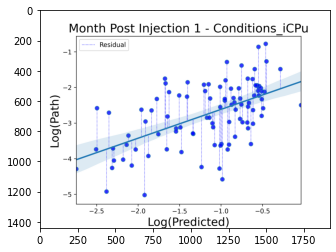

In [84]:
plt.imshow(image[0])

## Plotting Figure 4

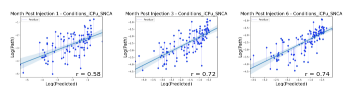

In [87]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

timepoint=[1,3,6]
image=[]
for tp in timepoint:
    Cor = Image.open("../Data_ReScience/SNCA/Predicted_VS_Path_MPI{}_iCPu_SNCA.png".format(tp))
    image.append(Cor)
    
fig = plt.figure()
G = gridspec.GridSpec(nrows=3, ncols=6)

axes_1 = fig.add_subplot(G[0:4, 0:2])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.annotate("A",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.58",(1250,1250), fontsize=6, color="black")
plt.imshow(image[0])

axes_2 = fig.add_subplot(G[0:4, 2:4])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.annotate("B",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.72",(1250,1250), fontsize=6, color="black")
plt.imshow(image[1])

axes_3 = fig.add_subplot(G[0:4, 4:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.annotate("C",(50,150), fontsize=7, color="black")
plt.annotate("r = 0.74",(1250,1250), fontsize=6, color="black")
plt.imshow(image[2])

plt.savefig('../Data_ReScience/SNCA/Fig4.png', dpi=300)
plt.savefig('../Data_ReScience/SNCA/Fig4.pdf', dpi=300)
plt.show()

## Plotting Figure 5

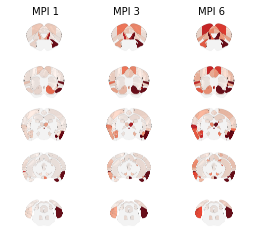

In [236]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender\PIR_MPIs/50um_Pir_MPI{}_Breg_{}_mm.png".format(tp,-section/1000))
        image.append(Cor)
        
fig = plt.figure()
G = gridspec.GridSpec(nrows=15, ncols=12, wspace=0.2)


axes_1_1 = fig.add_subplot(G[0:3, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[3:6, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[6:9, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[9:12, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[12:15, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])


###############


axes_1_3 = fig.add_subplot(G[0:3, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 3", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[5])

axes_2_3 = fig.add_subplot(G[3:6, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[6])

axes_3_3 = fig.add_subplot(G[6:9, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[7])

axes_4_3 = fig.add_subplot(G[9:12, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[8])

axes_5_3 = fig.add_subplot(G[12:15, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[9])


###############

axes_1_6 = fig.add_subplot(G[0:3, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 6", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[10])

axes_2_6 = fig.add_subplot(G[3:6, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[11])

axes_3_6 = fig.add_subplot(G[6:9, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[12])

axes_4_6 = fig.add_subplot(G[9:12, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[13])

axes_5_6 = fig.add_subplot(G[12:15, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[14])

plt.savefig('../Data_ReScience/Pir SN/Pir.png', dpi=300)
plt.savefig('../Data_ReScience/Pir SN/Pir.pdf', dpi=300)
plt.show()

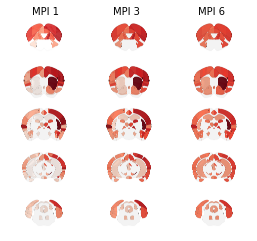

In [237]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender/SN_MPIs/50um_SNc_MPI{}_Breg_{}_mm.png".format(tp,section/1000))
        image.append(Cor)
        
fig = plt.figure()

G = gridspec.GridSpec(nrows=15, ncols=12, wspace=0.2)


axes_1_1 = fig.add_subplot(G[0:3, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[3:6, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[6:9, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[9:12, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[12:15, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])


###############


axes_1_3 = fig.add_subplot(G[0:3, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 3", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[5])

axes_2_3 = fig.add_subplot(G[3:6, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[6])

axes_3_3 = fig.add_subplot(G[6:9, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[7])

axes_4_3 = fig.add_subplot(G[9:12, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[8])

axes_5_3 = fig.add_subplot(G[12:15, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[9])


###############

axes_1_6 = fig.add_subplot(G[0:3, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(3000,-100,"MPI 6", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[10])

axes_2_6 = fig.add_subplot(G[3:6, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[11])

axes_3_6 = fig.add_subplot(G[6:9, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[12])

axes_4_6 = fig.add_subplot(G[9:12, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[13])

axes_5_6 = fig.add_subplot(G[12:15, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[14])

plt.savefig('../Data_ReScience/Pir SN/SN.png', dpi=300)
plt.savefig('../Data_ReScience/Pir SN/SN.pdf', dpi=300)
plt.show()

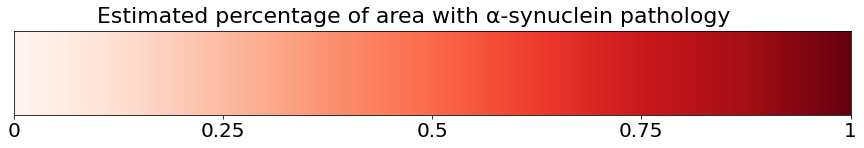

In [146]:
from matplotlib.colors import LinearSegmentedColormap

cmap = plt.get_cmap('Reds')

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    plt.figure(figsize=(15,3))
    plt.imshow([colors], extent=[0, 10, 0, 1])
    plt.xticks([0, 2.5, 5, 7.5 ,10], ['0', '0.25', '0.5','0.75','1'], fontsize=20)
    plt.yticks([])
    plt.text(1,1.1,'Estimated percentage of area with \u03B1-synuclein pathology', fontsize=22)
    #plt.text(10.5,0.6,'Estimated percentage of area with \u03B1-synuclein')
    plt.savefig("../Screenshot_Brainrender\SN_MPIs/colormap.png",dpi=300)
    plt.savefig("../Screenshot_Brainrender\SN_MPIs/colormap.pdf",dpi=300)
    plt.savefig("../Screenshot_Brainrender\PIR_MPIs/colormap.png",dpi=300)
    plt.savefig("../Screenshot_Brainrender\PIR_MPIs/colormap.pdf",dpi=300)
      
view_colormap("Reds")

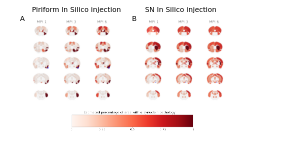

In [81]:
Pir = Image.open('../Data_ReScience/Pir SN/Pir.png')
SN = Image.open("../Data_ReScience/Pir SN/SN.png")
colormap = Image.open("../Screenshot_Brainrender/SN_MPIs/colormap.png")
                      
fig = plt.figure()
G = gridspec.GridSpec(nrows=10, ncols=15, wspace=0.000001, hspace=1)                    
axes_1_1 = fig.add_subplot(G[0:9, 0:7])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.text(795,0,"Piriform In Silico injection", ha="center", fontsize=7)
plt.annotate("A",(150,100), fontsize=7, color="black")
plt.annotate("*",(455,653), fontsize=4, color="blue")
plt.annotate("*",(807,653), fontsize=4, color="blue")
plt.annotate("*",(1159,653), fontsize=4, color="blue")

plt.imshow(Pir)

axes_1_2 = fig.add_subplot(G[0:9, 5:12])
xticks([]), yticks([])
plt.text(710,0,"SN In Silico injection", ha="center", fontsize=7)
plt.annotate("B",(150,100), fontsize=7, color="black")
plt.annotate("*",(412,810), fontsize=2, color="blue")
plt.annotate("*",(764,810), fontsize=2, color="blue")
plt.annotate("*",(1118,810), fontsize=2, color="blue")


#plt.annotate("B",(150,1050), fontsize=7, color="black")
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(SN)

axes_1_3 = fig.add_subplot(G[6:8, 2:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(colormap)

plt.savefig('../Data_ReScience/Pir SN/Fig5.png', dpi=600)
plt.savefig('../Data_ReScience/Pir SN/Fig5.pdf', dpi=600)
plt.show()

## Plotting Figure 3

## a) Vulnerability

In [234]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

resi_cpu = pd.read_csv('../output/model_output_MPI1_iCPu.csv')
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')
resi_cpu.head()
resi_cpu = resi_cpu.rename(columns={'Unnamed: 0': 'region'})

cmap = plt.get_cmap('bwr')
for r in resi_cpu.index:
    
    names = reg_names[reg_names['ROInames'] == resi_cpu.loc[r, 'region']]['BrainR']
    
    if len(names) > 1:
         resi_cpu.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        resi_cpu.loc[r, 'br_regions'] = names.values
        
for r in resi_cpu.index:
    
    if resi_cpu.loc[r, 'region'][0] == 'i':
        resi_cpu.loc[r, 'hem'] = 'right'
    elif resi_cpu.loc[r, 'region'][0] == 'c':
        resi_cpu.loc[r, 'hem'] = 'left' 
        
resi_cpu.head()
resi_cpu= resi_cpu.dropna() #Dropping the br_regions overlapping in brain render
resi_cpu.to_excel('saved_file.xlsx')
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]
for section in tqdm(list_coor):
    bregma = np.array([5400,  # AP    
          0,  # DV    
          5700,]) # ML

    bregma[0] = bregma[0] + section

    # Create a brainrender scene
    scene = Scene(inset=False,screenshots_folder="../Screenshot_Brainrender/residuals")
    frontal_camera = {
         'pos': (-19781, 3777, -5832),
         'viewup': (0, -1, 0),
         'clippingRange': (26465, 26836),
        'focalPoint': (5705, 3991, -5691),
         'distance': 25487}

   # Add brain regions
    for r in resi_cpu.index:

        region_to_plot = resi_cpu.loc[r, "br_regions"]
        color = cmap(resi_cpu.loc[r, 'residual'])[:3]

        scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=resi_cpu.loc[r, 'hem'], silhouette=True) #alpha=data_cpu.loc[r, 'MPI{}'.format(t)]


    plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
    plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
    plane_3 = scene.atlas.get_plane(plane="sagittal", norm=(0,0,-1), alpha=1, color="white")
    scene.slice(plane_1, close_actors=True)
    scene.slice(plane_2, close_actors=True)
    scene.slice(plane_3, close_actors=True)


    brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
    brainrender.settings.ROOT_ALPHA = 0.15
    brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
    brainrender.settings.OFFSCREEN = True
    brainrender.settings.SHOW_AXES = False
    brainrender.settings.BACKGROUND_COLOR = "white"
    scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
    scene.screenshot(name="50um_SNc_MPI1_Breg_{}_mm".format(-section/1000), scale = 3)
    img_totranspose = Image.open("../Screenshot_Brainrender/residuals/50um_SNc_MPI1_Breg_{}_mm.png".format(-section/1000))
    img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
    img_totranspose.save("../Screenshot_Brainrender/residuals/50um_SNc_MPI1_Breg_{}_mm.png".format(-section/1000))
    #title="-Coronal section Bregma {} mm -50um thickness- Seed = SN - MPI {}".format(-section/1000,t),
    scene.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Saving new screenshot at 50um_SNc_MPI1_Breg_2.1_mm.png

 20%|██        | 1/5 [00:11<00:47, 11.86s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_1.08_mm.png

 40%|████      | 2/5 [00:23<00:34, 11.66s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 1. 36_mm.png

 60%|██████    | 3/5 [00:35<00:23, 11.90s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 2. 82_mm.png

 80%|████████  | 4/5 [00:48<00:12, 12.33s/it]

Saving new screenshot at 50um_SNc_MPI1_Breg_- 4. 5_mm.png

100%|██████████| 5/5 [01:00<00:00, 12.12s/it]


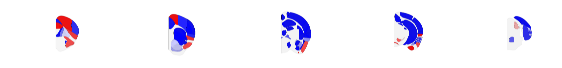

In [240]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender/residuals/50um_SNc_MPI1_Breg_{}_mm.png".format(-section/1000))
        image.append(Cor)
        
fig = plt.figure(figsize=(10,1))

G = gridspec.GridSpec(nrows=4, ncols=15)


axes_1_1 = fig.add_subplot(G[0:4, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[0:4, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[0:4, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[0:4, 9:12])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[0:4, 12:15])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])

plt.savefig('../Data_ReScience/residuals/vulnerability.png', dpi=300)
plt.savefig('../Data_ReScience/residuals/vulnerability.pdf', dpi=300)
plt.show()

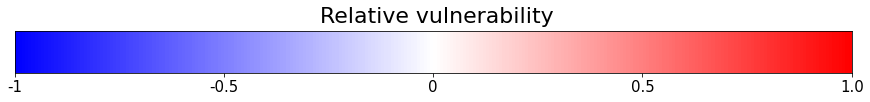

In [159]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    plt.figure(figsize=(15,3))
    plt.imshow([colors], extent=[0, 10, 0, 0.5])
    plt.xticks([0, 2.5, 5, 7.5 ,10], ['-1', '-0.5', '0','0.5','1.0'],fontsize=15)
    plt.yticks([])
    plt.text(3.65,0.6,'Relative vulnerability',fontsize=22)
    #plt.text(10.5,0.6,'Estimated percentage of area with \u03B1-synuclein')
    plt.savefig('../Data_ReScience/residuals/scale.png', dpi=300)
    plt.savefig('../Data_ReScience/residuals/scale.pdf', dpi=300)
      
view_colormap("bwr")

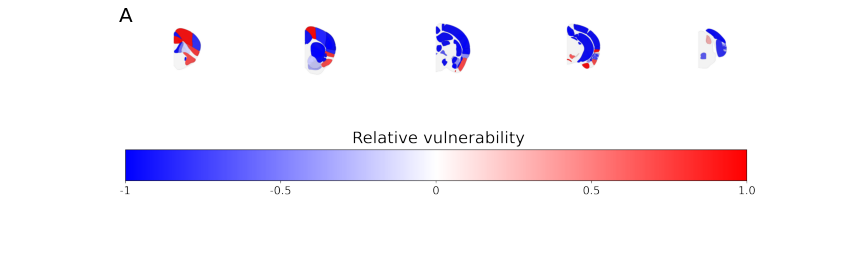

In [21]:
vul = Image.open('../Data_ReScience/residuals/vulnerability.png')
colormap = Image.open('../Data_ReScience/residuals/scale.png')
                      
fig = plt.figure(figsize=(15,6))
G = gridspec.GridSpec(nrows=10, ncols=10)
F = gridspec.GridSpec(nrows=10, ncols=10)

axes_1_1 = fig.add_subplot(G[0:6, 0:10])
plt.annotate("A",(400,50), fontsize=20, color="black")
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(vul)

axes_1_2 = fig.add_subplot(F[4:9, 0:10])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(colormap)

plt.savefig('../Data_ReScience/residuals/Fig3_A.png', dpi=600)
plt.savefig('../Data_ReScience/residuals/Fig3_A.pdf', dpi=600)
plt.show()

## b) SNCA application

In [203]:
from vedo import embedWindow
embedWindow(None)

from brainrender import Scene
import brainrender
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.getcwd()
reg_names = pd.read_excel('./Data83018/BrainR_ROInames.xlsx')
snca_exp = pd.read_csv('Data83018/SncaExpression.csv', header=None, )
snca_exp.head()
snca_exp.columns= ["Regions","SNCA_val"]
snca_exp.head()


for r in snca_exp.index:
    
    names = reg_names[reg_names['ROInames'] == snca_exp.loc[r, 'Regions']]['BrainR']
    
    if len(names) > 1:
         snca_exp.loc[r, 'br_regions'] = list(names)[0]
    elif len(names) == 1:    
        snca_exp.loc[r, 'br_regions'] = names.values   
        
for r in snca_exp.index:
    
    if snca_exp.loc[r, 'Regions'][0] == 'i':
        snca_exp.loc[r, 'hem'] = 'right'
    elif snca_exp.loc[r, 'Regions'][0] == 'c':
        snca_exp.loc[r, 'hem'] = 'left'
        
snca_exp.head()
snca_exp.to_excel('saved_file.xlsx')
snca_exp= snca_exp.dropna() #Dropping the br_regions overlapping in brain render
#snca_exp.to_excel('saved_file_drop.xlsx')
snca_exp.head()

,Regions,SNCA_val,br_regions,hem
0,iM2,24.364167,MOs,right
1,iM1,17.445526,MOp,right
2,iAI,17.962500,AId,right
3,iPrL,21.480909,PL,right
4,iMO,15.802143,ORBm,right


In [218]:
max_val= np.max(snca_exp["SNCA_val"].values)
min_val= np.min(snca_exp["SNCA_val"].values)

snca_exp["SNCA_val"]=(snca_exp["SNCA_val"] - min_val)/(max_val-min_val)

In [229]:
# Saving BrainRender SNCA expression
cmap= plt.get_cmap("YlOrRd")
list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoints = [1,3,6]
for section in tqdm(list_coor):
    bregma = np.array([5400,  # AP    
          0,  # DV    
          5700,]) # ML

    bregma[0] = bregma[0] + section

    # Create a brainrender scene
    scene = Scene(inset=False,screenshots_folder="../Screenshot_Brainrender/SNCA_exp")
    frontal_camera = {
         'pos': (-19781, 3777, -5832),
         'viewup': (0, -1, 0),
         'clippingRange': (26465, 26836),
        'focalPoint': (5705, 3991, -5691),
         'distance': 25487}

   # Add brain regions
    for r in snca_exp.index:

        region_to_plot = snca_exp.loc[r, "br_regions"]
        color = cmap(snca_exp.loc[r, 'SNCA_val'])[:3]

        scene.add_brain_region(region_to_plot, color=color, alpha=1, hemisphere=snca_exp.loc[r, 'hem'], silhouette=True) #alpha=snca_exp.loc[r, 'SNCA_val'])


    plane_1 = scene.atlas.get_plane(pos=bregma+50, plane="frontal", norm=(-1, 0, 0), alpha=1, color="white") # Thickness: 150 um
    plane_2 = scene.atlas.get_plane(pos=bregma-50, plane="frontal", norm=(1, 0, 0), alpha=1, color="white")
    plane_3 = scene.atlas.get_plane(plane="sagittal", norm=(0,0,-1), alpha=1, color="white")
    scene.slice(plane_1, close_actors=True)
    scene.slice(plane_2, close_actors=True)
    scene.slice(plane_3, close_actors=True)


    brainrender.settings.SHADER_STYLE = "cartoon" #[metallic, plastic, shiny, glossy]
    brainrender.settings.ROOT_ALPHA = 0.15
    brainrender.settings.ROOT_COLOR  = [0.4, 0.4, 0.4]
    brainrender.settings.OFFSCREEN = True
    brainrender.settings.SHOW_AXES = False
    brainrender.settings.BACKGROUND_COLOR = "white"
    scene.render(atlas_name='allen_mouse_50um', camera= frontal_camera, zoom=1.5)
    scene.screenshot(name="SNCA_exp_Breg{}.png".format(-section/1000), scale = 3)
    img_totranspose = Image.open("../Screenshot_Brainrender/SNCA_exp/SNCA_exp_Breg{}.png".format(-section/1000))
    img_totranspose = img_totranspose.transpose(Image.FLIP_LEFT_RIGHT)
    img_totranspose.save("../Screenshot_Brainrender/SNCA_exp/SNCA_exp_Breg{}.png".format(-section/1000))
    #title="-Coronal section Bregma {} mm -50um thickness- Seed = SN - MPI {}".format(-section/1000,t),
    scene.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Saving new screenshot at SNCA_exp_Breg2. 1. png

 20%|██        | 1/5 [00:12<00:48, 12.08s/it]

Saving new screenshot at SNCA_exp_Breg1. 08. png

 40%|████      | 2/5 [00:23<00:35, 11.96s/it]

Saving new screenshot at SNCA_exp_Breg- 1.36 .png

 60%|██████    | 3/5 [00:35<00:23, 11.95s/it]

Saving new screenshot at SNCA_exp_Breg- 2.82 .png

 80%|████████  | 4/5 [00:48<00:12, 12.12s/it]

Saving new screenshot at SNCA_exp_Breg- 4.5 .png

100%|██████████| 5/5 [01:00<00:00, 12.11s/it]


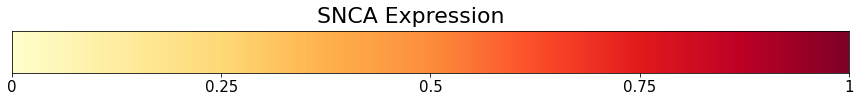

In [222]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    plt.figure(figsize=(15,3))
    plt.imshow([colors], extent=[0, 10, 0, 0.5])
    plt.xticks([0, 2.5, 5, 7.5 ,10], ["0", '0.25', '0.5','0.75','1'],fontsize=15)
    plt.yticks([])
    plt.text(3.65,0.6,'SNCA Expression',fontsize=22)
    #plt.text(10.5,0.6,'Estimated percentage of area with \u03B1-synuclein')
    plt.savefig('../Screenshot_Brainrender/SNCA_exp/scale.png', dpi=300)
    plt.savefig('../Screenshot_Brainrender/SNCA_exp/scale.pdf', dpi=300)
      
view_colormap("YlOrRd")

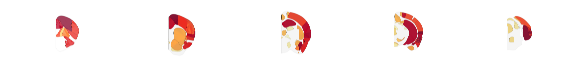

In [231]:
from pylab import *
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

list_coor = [-2100, -1080, +1360, +2820, +4500] # Bregma corresponding coordinates
timepoint=[1,3,6]
image=[]
for tp in timepoint:
    for section in list_coor:
        Cor = Image.open("../Screenshot_Brainrender/SNCA_exp/SNCA_exp_Breg{}.png".format(-section/1000))
        image.append(Cor)
        
fig = plt.figure(figsize=(10,1))

G = gridspec.GridSpec(nrows=4, ncols=15)


axes_1_1 = fig.add_subplot(G[0:4, 0:3])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(image[0])

axes_2_1 = fig.add_subplot(G[0:4, 3:6])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[1])

axes_3_1 = fig.add_subplot(G[0:4, 6:9])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[2])

axes_4_1 = fig.add_subplot(G[0:4, 9:12])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[3])

axes_5_1 = fig.add_subplot(G[0:4, 12:15])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.imshow(image[4])

plt.savefig('../Data_ReScience/SNCA_exp/SNCA_exp_summary.png', dpi=300)
plt.savefig('../Data_ReScience/SNCA_exp/SNCA_exp_summary.pdf', dpi=300)
plt.show()

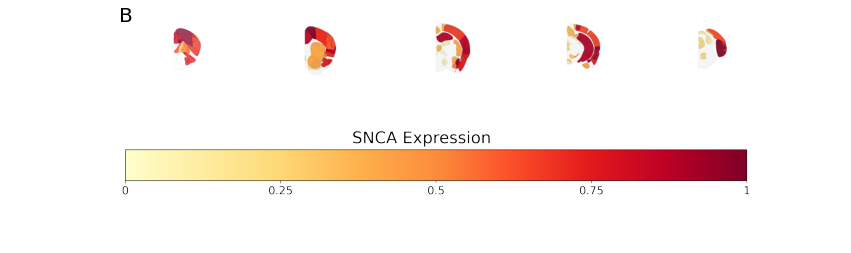

In [19]:
vul = Image.open('../Data_ReScience/SNCA_exp/SNCA_exp_summary.png')
colormap = Image.open('../Screenshot_Brainrender/SNCA_exp/scale.png')
                      
fig = plt.figure(figsize=(15,6))
G = gridspec.GridSpec(nrows=10, ncols=10)
F = gridspec.GridSpec(nrows=10, ncols=10)

axes_1_1 = fig.add_subplot(G[0:6, 0:10])
plt.annotate("B",(400,50), fontsize=20, color="black")
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(vul)

axes_1_2 = fig.add_subplot(F[4:9, 0:10])
xticks([]), yticks([])
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
#plt.text(3250,-100,"MPI 1", ha="right")
# plt.annotate("A",(50,150), fontsize=7, color="black")
plt.imshow(colormap)

plt.savefig('../Data_ReScience/SNCA_exp/Fig3_B.png', dpi=600)
plt.savefig('../Data_ReScience/SNCA_exp/Fig3_B.pdf', dpi=600)
plt.show()